In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# File and directory operations
import os

# Geospatial data processing and analysis
import geopandas as gpd
import osmnx as ox
import networkx as nx
import momepy
import rioxarray
import xrspatial
from rasterio.enums import Resampling
import pyproj
import shapely.geometry as sg
from shapely.ops import transform

# Geospatial data access and catalogs
import pystac_client
import planetary_computer
import odc.stac

# Date and time manipulation
from datetime import datetime, timedelta
from time import time

# Progress tracking
from tqdm import tqdm

# Images
from PIL import Image
import requests
from io import BytesIO

c:\Users\ygrin\anaconda3\envs\ADSthesis\Lib\site-packages\libpysal\cg\alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
c:\Users\ygrin\anaconda3\envs\ADSthesis\Lib\site-packages\libpysal\cg\alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
c:\Users\ygrin\anaconda3\envs\ADSthesis\Lib\site-packages\libpysal\cg\alpha_shape

In [2]:
# Test data
test_path = "C:/Users/ygrin/Documents/Studie - MSc ADS/Utrecht University/Block 4 - Thesis/TestData/"
test_results_path = "C:/Users/ygrin/Documents/Studie - MSc ADS/Utrecht University/Block 4 - Thesis/TestData/Results/"
single_point = gpd.read_file(test_path + "Test_single_home_location.gpkg")
multi_point = gpd.read_file(test_path + "Test_multiple_home_locations.gpkg")
#polygon = gpd.read_file(test_path + "TestArea.gpkg")
ndvi = rioxarray.open_rasterio(test_path + "NDVI_data_test.tif")
land_cover = rioxarray.open_rasterio(test_path + "Landcover_data_test.tif")
#network = gpd.read_file(test_path + "test_network.gpkg", layer='edges')
network = gpd.read_file(test_path + "test_network_shp.shp")
polygon = gpd.read_file(test_path + "test_polygon.gpkg")
canopy_single = gpd.read_file(test_path + "Canopy_single_home_500m.gpkg")

single_point_geographic = single_point.to_crs('epsg:4326')

In [3]:
# Function to create isochrone polygon of network
def make_iso_poly(buffer_graph, subgraph, edge_buff=25, node_buff=0):
    #Note: based on code by gboeing, source: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb
    node_points = [sg.Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)] # Create list of point geometries existing of x and y coordinates for each node in subgraph retrieved from previous step
    nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points) # Create geodataframe containing data from previous step
    nodes_gdf = nodes_gdf.set_index("id") # Set index to node ID

    edge_lines = []
    for n_fr, n_to in subgraph.edges(): # Iterate over edges in subgraph
        f = nodes_gdf.loc[n_fr].geometry # Retrieve geometry of the 'from' node of the edge
        t = nodes_gdf.loc[n_to].geometry # Retrieve geometry of the 'to' node of the edge
        edge_lookup = buffer_graph.get_edge_data(n_fr, n_to)[0].get("geometry", sg.LineString([f, t])) # Retrieve edge geometry between from and to nodes
        edge_lines.append(edge_lookup) # Append edge geometry to list of edge lines

    n = nodes_gdf.buffer(node_buff).geometry # Create buffer around the nodes
    e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry # Create buffer around the edges
    all_gs = list(n) + list(e) # Concatenate nodes and edges
    isochrone_poly = gpd.GeoSeries(all_gs).unary_union # Create polygon of the concatenated nodes and edges

    isochrone_poly = sg.Polygon(isochrone_poly.exterior) # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
    
    return isochrone_poly

# Greenness Availability -- Mean NDVI

In [4]:
def get_mean_NDVI(point_of_interest_file, ndvi_raster_file=None, crs_epsg=None, polygon_type="neighbourhood", buffer_type=None, 
                  buffer_dist=None, network_type=None, trip_time=None, travel_speed=None, year=datetime.now().year, 
                  write_to_file=True, save_ndvi=True, output_dir=os.getcwd()):
    ### Step 1: Read and process user inputs, check conditions
    poi = gpd.read_file(point_of_interest_file)
    # Verify that locations are either all provided using point geometries or all provided using polygon geometries
    if all(poi['geometry'].geom_type == 'Point') or all(poi['geometry'].geom_type == 'Polygon'):
        geom_type = poi.iloc[0]['geometry'].geom_type
    else:
        raise ValueError("Please make sure all geometries are of 'Point' type or all geometries are of 'Polygon' type and re-run the function")
    
    # Make sure the type of polygon is specified if poi file contains polygon geometries
    if geom_type == "Polygon":
        if polygon_type not in ["neighbourhood", "house"]:
            raise ValueError("Please make sure that the polygon_type argument is set to either 'neighbourhood' or 'house'")

    # In case of house polygons, transform to centroids
    if geom_type == "Polygon":
        if polygon_type not in ["neighbourhood", "house"]:
            raise TypeError("Please make sure that the polygon_type argument is set to either 'neighbourhood' or 'house'")
        if polygon_type == "house":
            print("Changing geometry type to Point by computing polygon centroids...")
            poi['geometry'] = poi['geometry'].centroid
            geom_type = poi.iloc[0]['geometry'].geom_type
            print("Done \n")

    # Make sure buffer distance and type are set in case of point geometries
    if geom_type == "Point":
        if buffer_type not in ["euclidian", "network"]:
            raise ValueError("Please make sure that the buffer_type argument is set to either 'euclidian' or 'network' and re-run the function")

    # Make sure CRS is projected rather than geographic
    if not poi.crs.is_projected:
        if crs_epsg is None:
            print("Warning: The CRS of the PoI dataset is currently geographic, therefore it will now be projected to CRS with EPSG:3395")
            epsg = 3395
            poi.to_crs(f"EPSG:{epsg}", inplace=True)
        else:
            print(f"Warning: The CRS of the PoI dataset is currently geographic, therefore it will now be projected to EPSG:{crs_epsg} as specified")
            epsg = crs_epsg
            poi.to_crs(f"EPSG:{epsg}", inplace=True)
    else:
        epsg = poi.crs.to_epsg()

    # Create epsg transformer to use planetary computer and OSM
    epsg_transformer = pyproj.Transformer.from_crs(f"epsg:{epsg}", "epsg:4326") 

    # Make sure poi dataframe contains ID column
    if "id" in poi.columns:
        if poi['id'].isnull().values.any():
            poi['id'] = poi['id'].fillna(pd.Series(range(1, len(poi) + 1))).astype(int)
    else:
        poi['id'] = pd.Series(range(1, len(poi) + 1)).astype(int)

    # Make sure the buffer_type argument has a valid value if not None
    if buffer_type is not None and buffer_type not in ["euclidean", "network"]:
        raise ValueError("Please make sure that the buffer_type argument is set to either 'euclidian' or 'network' and re-run the function")

    # If buffer type is set to euclidian, make sure that the buffer distance is set
    if buffer_type == "euclidian":
            if not isinstance(buffer_dist, int) or (not buffer_dist > 0):
                raise TypeError("Please make sure that the buffer_dist argument is set to a positive integer")  
    
    # If buffer type is set to network, make sure that either the buffer distance is set or both trip_time and travel_speed are set
    if buffer_type == "network":
        if not isinstance(buffer_dist, int) or (not buffer_dist > 0):
            if not isinstance(travel_speed, int) or (not travel_speed > 0) or (not isinstance(trip_time, int) or (not trip_time > 0)):
                raise TypeError("Please make sure that either the buffer_dist argument is set to a positive integer or both the travel_speed and trip_time are set to positive integers")
            else:
                speed_time = True # Set variable stating whether buffer_dist is calculated using travel speed and trip time
                # Convert km per hour to m per minute
                meters_per_minute = travel_speed * 1000 / 60 
                # Calculate max distance that can be travelled based on argument specified by user and add 25% to account for edge effects
                buffer_dist = trip_time * meters_per_minute * 1.25
        else:
            # Buffer_dist and combination of travel_speed and trip_time cannot be set at same time
            if isinstance(travel_speed, int) and travel_speed > 0 and isinstance(trip_time, int) and trip_time > 0:
                raise TypeError("Please make sure that one of the following requirements is met:\
                                \n1. If buffer_dist is set, travel_speed and trip_time should not be set\
                                \n2. If travel_speed and trip_time are set, buffer_dist shoud not be set")
            speed_time = False

    # Create polygon in which all pois are located to extract data from PC/OSM, incl. buffer if specified
    if buffer_dist is None:
        poi_polygon = sg.box(*poi.total_bounds)
    else:
        poi_polygon = sg.box(*poi.total_bounds).buffer(buffer_dist)

    # Retrieve NDVI raster, use planetary computer if not provided by user 
    if ndvi_raster_file is None:
        print("Retrieving NDVI raster through planetary computer...")
        start_ndvi_retrieval = time()

        # Transform CRS to comply with planetary computer requirements
        bounding_box_pc = transform(epsg_transformer.transform, poi_polygon).bounds 
        # Swap coords order to match with planetary computer format
        bounding_box_pc = [bounding_box_pc[1], bounding_box_pc[0], bounding_box_pc[3], bounding_box_pc[2]] 

        # Query planetary computer
        catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",modifier=planetary_computer.sign_inplace)
        # Obtain Area of Interest
        time_of_interest = f"{year}-01-01/{year}-12-30" 
        # Search Data
        search = catalog.search(collections=["sentinel-2-l2a"],
                                bbox=bounding_box_pc,
                                datetime=time_of_interest,
                                query={"eo:cloud_cover": {"lt": 20}})
        # Obtain Data
        items = search.item_collection()
        # Create dataframe from planetary computer's item collection dictionary
        items_df = gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
        # Make sure only images are maintained that contain all points/polygons of interest
        items_df_poi = items_df[items_df.geometry.contains(sg.box(*bounding_box_pc))]
        # Determine lowest percentage of cloud cover among filtered items
        lowest_cloud_cover = items_df_poi['eo:cloud_cover'].min()
        # Filter the satellite image which has the lowest cloud cover percentage
        item_to_select = items_df_poi[items_df_poi['eo:cloud_cover'] == lowest_cloud_cover]
        # Select item that matches the filters above and will be used to compose ndvi raster
        selected_item = next(item for item in items if item.properties["s2:granule_id"] == item_to_select.iloc[0]['s2:granule_id'])
        # Obtain Bands of Interest
        selected_item_data = odc.stac.stac_load([selected_item], bands = ['red', 'green', 'blue', 'nir'], bbox = bounding_box_pc).isel(time=0)
        # Calculate NDVI values
        ndvi = xrspatial.multispectral.ndvi(selected_item_data['nir'], selected_item_data['red'])
        # Reproject to original poi CRS
        ndvi_src = ndvi.rio.reproject(f"EPSG:{epsg}", resampling= Resampling.nearest, nodata=np.nan)

        # Provide information on satellite image that was used to user
        print(f"Information on the satellite image retrieved from planetary computer, use to calculate NDVI values:\
              \n   Date on which image was generated: {selected_item.properties['s2:generation_time']}\
              \n   Percentage of cloud cover: {selected_item.properties['eo:cloud_cover']}\
              \n   Percentage of pixels with missing data {selected_item.properties['s2:nodata_pixel_percentage']}")

        # Save satellite image that was used in case user specifies so
        if save_ndvi:
            # Retrieve the image URL
            image_url = selected_item.assets["rendered_preview"].href
            # Download the image data
            response = requests.get(image_url)
            # Create a PIL Image object from the downloaded image data
            image = Image.open(BytesIO(response.content))
            # Create directory if the one specified by the user does not yet exist
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            # Get filename of the poi file to append information to it
            input_filename, _ = os.path.splitext(os.path.basename(point_of_interest_file))
            # Save the image to a file
            image.save(os.path.join(output_dir, f"{input_filename}_ndvi_satellite_image.png"))
            ndvi_src.rio.to_raster(os.path.join(output_dir, f"{input_filename}_ndvi_raster.tif"))
            print("Satellite image and created NDVI raster successfully saved to file")
        end_ndvi_retrieval = time()
        elapsed_ndvi_retrieval = end_ndvi_retrieval - start_ndvi_retrieval
        print(f"Done, running time: {str(timedelta(seconds=elapsed_ndvi_retrieval))} \n")
    else:
        # Read ndvi raster provided by user
        ndvi_src = rioxarray.open_rasterio(ndvi_raster_file)
        # Make sure that ndvi raster has same CRS as poi file
        if not ndvi_src.rio.crs.to_epsg() == epsg:
            print("Adjusting CRS of NDVI file to match with Point of Interest CRS...")
            ndvi_src.rio.write_crs(f'EPSG:{epsg}', inplace=True)
            print("Done \n")

        # Make sure all points of interest are within or do at least intersect (in case of polygons) the NDVI raster provided
        if not all(geom.within(sg.box(*ndvi_src.rio.bounds())) for geom in poi['geometry']):
            if geom_type == "Point":
                raise ValueError("Not all points of interest are within the NDVI file provided, please make sure they are and re-run the function")
            else:
                if not all(geom.intersects(sg.box(*ndvi_src.rio.bounds())) for geom in poi['geometry']):
                    raise ValueError("Not all polygons of interest are within, or do at least partly intersect, with the area covered by the NDVI file provided, please make sure they are/do and re-run the function")
                else:
                    print("Warning: Not all polygons of interest are completely within the area covered by the NDVI file provided, results will be based on intersecting part of polygons involved \n") 

    ### Step 2: Construct the Area of Interest based on the arguments as defined by user
    if buffer_type is None:
        # Buffer type == None implies that provided polygons serve as areas of interest
        aoi_gdf = gpd.GeoDataFrame(geometry=poi['geometry'])
    else:
        if buffer_type == "euclidian":
            # Create area of interest based on euclidian distance
            aoi_gdf = gpd.GeoDataFrame(geometry=poi['geometry'].buffer(buffer_dist))
        else:
            # Make sure network type argument has valid value
            if network_type not in ["walk", "bike", "drive", "all"]:
                raise ValueError("Please make sure that the network_type argument is set to either 'walk', 'bike, 'drive' or 'all', and re-run the function")
            
            # If poi file still contains polygon geometries, compute centroids so that isochrone maps can be created
            if geom_type == "Polygon":
                print("Changing geometry type to Point by computing polygon centroids so that isochrones can be retrieved...")
                poi['geometry'] = poi['geometry'].centroid
                print("Done \n")
            
            print("Retrieving network within total bounds of point(s) of interest, extended by buffer distance as specified...")
            start_network_retrieval = time()
            # Transform total bounds polygon of poi file to 4326 for OSM
            polygon_gdf_wgs = gpd.GeoDataFrame(geometry=[poi_polygon], crs=f"EPSG:{epsg}").to_crs("EPSG:4326") 
            # Extract polygon in EPSG 4326 
            wgs_polygon = polygon_gdf_wgs['geometry'].values[0]        
            # Retrieve street network for desired network type
            graph = ox.graph_from_polygon(wgs_polygon, network_type=network_type) 
            # Project street network graph back to original poi CRS
            graph_projected = ox.project_graph(graph, to_crs=f"EPSG:{epsg}") 
            end_network_retrieval = time()
            elapsed_network_retrieval = end_network_retrieval - start_network_retrieval
            print(f"Done, running time: {str(timedelta(seconds=elapsed_network_retrieval))} \n")             

            # Compute isochrone areas for points of interest
            aoi_geometry = []
            for geom in tqdm(poi['geometry'], desc = 'Retrieving isochrone for point(s) of interest'):
                # Find node which is closest to point location as base for next steps
                center_node = ox.distance.nearest_nodes(graph_projected, geom.x, geom.y) 
                # Create subgraph around point of interest for efficiency purposes
                buffer_graph = nx.ego_graph(graph_projected, center_node, radius=buffer_dist*2, distance="length")
                # Calculate the time it takes to cover each edge's distance if speed_time is True
                if speed_time:
                    for _, _, _, data in buffer_graph.edges(data=True, keys=True): 
                        data["time"] = data["length"] / meters_per_minute
                    # Create sub graph of the street network which contains only parts which can be reached within specified travel parameters
                    subgraph = nx.ego_graph(buffer_graph, center_node, radius=trip_time, distance="time") 
                else:
                    # Create sub graph of the street network which contains only parts which can be reached within specified travel parameters
                    subgraph = nx.ego_graph(buffer_graph, center_node, radius=buffer_dist, distance="length") 
                # Compute isochrones, see separate function for line by line explanation
                isochrone_poly = make_iso_poly(buffer_graph=buffer_graph, subgraph=subgraph) 
                aoi_geometry.append(isochrone_poly)

            # Create geodataframe of isochrone geometries
            aoi_gdf = gpd.GeoDataFrame(geometry=aoi_geometry, crs=f"EPSG:{epsg}")
            print("Note: creation of isochrones based on code by gboeing, source: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb \n")             
    
    ### Step 3: Calculate mean NDVI values and write results to file
    print("Calculating mean NDVI values...")
    start_calc = time()
    # Check whether areas of interest, created in previous steps, are fully covered by the ndvi raster, provide warning if not
    if not all(geom.within(sg.box(*ndvi_src.rio.bounds())) for geom in aoi_gdf['geometry']):
        print(f"Warning: Not all buffer zones for the {geom_type}s of Interest are completely within the area covered by the NDVI raster, note that results will be based on the intersecting part of the buffer zone")
    # Calculate mean ndvi for geometries in poi file
    poi['mean_NDVI'] = aoi_gdf.apply(lambda row: ndvi_src.rio.clip([row.geometry]).clip(min=0).mean().values.round(3), axis=1)
    end_calc = time()
    elapsed_calc = end_calc - start_calc
    print(f"Done, running time: {str(timedelta(seconds=elapsed_calc))} \n")

    if write_to_file:
        print("Writing results to new geopackage file in specified directory...")
        # Create directory if output directory specified by user does not yet exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        # Retrieve filename from original poi file to add information to it while writing to file
        input_filename, _ = os.path.splitext(os.path.basename(point_of_interest_file))
        poi.to_file(os.path.join(output_dir, f"{input_filename}_ndvi_added.gpkg"), driver="GPKG")
        print("Done")
    
    return poi

In [5]:
mean_ndvi = get_mean_NDVI(point_of_interest_file=test_path + "Test_single_home_location.gpkg", ndvi_raster_file=test_path + "NDVI_data_test.tif",
                          buffer_type="network", travel_speed=5, trip_time=10, network_type='walk', output_dir=test_results_path)

Retrieving network within total bounds of point(s) of interest, extended by buffer distance as specified...
Done, running time: 0:00:07.688931 



Retrieving isochrone for point(s) of interest: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


Note: creation of isochrones based on code by gboeing, source: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb 

Calculating mean NDVI values...
Done, running time: 0:00:00.185154 

Writing results to new geopackage file in specified directory...
Done


In [6]:
mean_ndvi

,id,geometry,mean_NDVI
0,1,POINT (387164.991 394443.414),0.157


In [7]:
mean_ndvi = get_mean_NDVI(point_of_interest_file=test_path + "Test_multiple_home_locations.gpkg", buffer_dist=500, 
                          buffer_type="network", network_type='bike', output_dir=test_results_path, year=2022)

Retrieving NDVI raster through planetary computer...
Information on the satellite image retrieved from planetary computer, use to calculate NDVI values:              
   Date on which image was generated: 2022-08-12T23:41:32.330818Z              
   Percentage of cloud cover: 0.003142              
   Percentage of pixels with missing data 0.000232
Satellite image and created NDVI raster successfully saved to file
Done, running time: 0:00:11.498362 

Retrieving network within total bounds of point(s) of interest, extended by buffer distance as specified...
Done, running time: 0:00:10.492538 



Retrieving isochrone for point(s) of interest: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


Note: creation of isochrones based on code by gboeing, source: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb 

Calculating mean NDVI values...
Done, running time: 0:00:00.326005 

Writing results to new geopackage file in specified directory...
Done


In [8]:
mean_ndvi

,id,geometry,mean_NDVI
0,1,POINT (388644.249 392861.634),0.253
1,2,POINT (385981.911 393805.494),0.226
2,3,POINT (388631.230 395322.181),0.247


# Greenness Availability -- Land Cover Percentages

In [9]:
# define function to calculate land cover percentages for a single geometry
def calculate_landcover_percentages(landcover_src, geometry):
    # Clip landcover raster to area of interest
    clipped = landcover_src.rio.clip([geometry]).clip(min=0) 
    # Count the occurrences of all unique raster values
    unique, counts = np.unique(clipped.values, return_counts=True) 
    # Calculate total nr. of occurrences 
    total = counts.sum() 
    # Calculate percentages for each class
    percentages = {value: str((count / total * 100).round(3)) + "%" for value, count in zip(unique, counts)} 
    return percentages

In [10]:
def get_landcover_percentages(point_of_interest_file, landcover_raster_file=None, crs_epsg=None, polygon_type="neighbourhood",
                              buffer_type=None, buffer_dist=None, network_type=None, trip_time=None, travel_speed=None, 
                              write_to_file=True, save_lulc=True, output_dir=os.getcwd()):
    ### Step 1: Read and process user input, check conditions
    poi = gpd.read_file(point_of_interest_file)
    # Make sure that geometries in poi file are either all provided using point geometries or all using polygon geometries
    if all(poi['geometry'].geom_type == 'Point') or all(poi['geometry'].geom_type == 'Polygon'):
        geom_type = poi.iloc[0]['geometry'].geom_type
    else:
        raise ValueError("Please make sure all geometries are of 'Point' type or all geometries are of 'Polygon' type and re-run the function")

    # Make sure type of polygon is specified in case poi file contains polygon geometries
    if geom_type == "Polygon":
        if polygon_type not in ["neighbourhood", "house"]:
            raise ValueError("Please make sure that the polygon_type argument is set to either 'neighbourhood' or 'house'")

    # In case of house polygons, transform to centroids
    if geom_type == "Polygon":
        if polygon_type not in ["neighbourhood", "house"]:
            raise TypeError("Please make sure that the polygon_type argument is set to either 'neighbourhood' or 'house'")
        if polygon_type == "house":
            print("Changing geometry type to Point by computing polygon centroids...")
            poi['geometry'] = poi['geometry'].centroid
            geom_type = poi.iloc[0]['geometry'].geom_type
            print("Done \n")

    # Make sure buffer distance and type are set in case of point geometries
    if geom_type == "Point":
        if buffer_type not in ["euclidian", "network"]:
            raise ValueError("Please make sure that the buffer_type argument is set to either 'euclidian' or 'network' and re-run the function")

    # Make sure CRS is projected rather than geographic
    if not poi.crs.is_projected:
        if crs_epsg is None:
            print("Warning: The CRS of the PoI dataset is currently geographic, therefore it will now be projected to CRS with EPSG:3395")
            epsg = 3395
            poi.to_crs(f"EPSG:{epsg}", inplace=True)
        else:
            print(f"Warning: The CRS of the PoI dataset is currently geographic, therefore it will now be projected to EPSG:{crs_epsg} as specified")
            epsg = crs_epsg
            poi.to_crs(f"EPSG:{epsg}", inplace=True)
    else:
        epsg = poi.crs.to_epsg()

    # Make sure poi dataframe contains ID column
    if "id" in poi.columns:
        if poi['id'].isnull().values.any():
            poi['id'] = poi['id'].fillna(pd.Series(range(1, len(poi) + 1))).astype(int)
    else:
        poi['id'] = pd.Series(range(1, len(poi) + 1)).astype(int)

    # Make sure the buffer_type argument has a valid value if not None
    if buffer_type is not None and buffer_type not in ["euclidean", "network"]:
        raise ValueError("Please make sure that the buffer_type argument is set to either 'euclidian' or 'network' and re-run the function")

    # If buffer type is set to euclidian, make sure that the buffer distance is set
    if buffer_type == "euclidian":
        if not isinstance(buffer_dist, int) or (not buffer_dist > 0):
            raise TypeError("Please make sure that the buffer_dist argument is set to a positive integer")  
    
    # If buffer type is set to network, make sure that either the buffer distance is set or both trip_time and travel_speed are set
    if buffer_type == "network":
        if not isinstance(buffer_dist, int) or (not buffer_dist > 0):
            if not isinstance(travel_speed, int) or (not travel_speed > 0) or (not isinstance(trip_time, int) or (not trip_time > 0)):
                raise TypeError("Please make sure that either the buffer_dist argument is set to a positive integer or both the travel_speed and trip_time are set to positive integers")
            else:
                speed_time = True # Set variable stating whether buffer_dist is calculated using travel speed and trip time
                # Convert km per hour to m per minute
                meters_per_minute = travel_speed * 1000 / 60 
                # Calculate max distance that can be travelled based on argument specified by user and add 25% to account for edge effects
                buffer_dist = trip_time * meters_per_minute * 1.25
        else:
            # Buffer_dist and combination of travel_speed and trip_time cannot be set at same time
            if isinstance(travel_speed, int) and travel_speed > 0 and isinstance(trip_time, int) and trip_time > 0:
                raise TypeError("Please make sure that one of the following requirements is met:\
                                \n1. If buffer_dist is set, travel_speed and trip_time should not be set\
                                \n2. If travel_speed and trip_time are set, buffer_dist shoud not be set")
            speed_time = False
            
    # Create polygon in which all pois are located to extract data from PC/OSM, incl. buffer if specified
    if buffer_dist is None:
        poi_polygon = sg.box(*poi.total_bounds)
    else:
        poi_polygon = sg.box(*poi.total_bounds).buffer(buffer_dist)

    if landcover_raster_file is None:
        # Create epsg transformer to use planetary computer
        epsg_transformer = pyproj.Transformer.from_crs(f"epsg:{epsg}", "epsg:4326")
        print("Retrieving landcover class raster through planetary computer...")
        start_landcover_retrieval = time()
        # transform CRS to comply with planetary computer requirements
        bounding_box_pc = transform(epsg_transformer.transform, poi_polygon).bounds  
        # Swap coords order to match with planetary computer format
        bounding_box_pc = [bounding_box_pc[1], bounding_box_pc[0], bounding_box_pc[3], bounding_box_pc[2]] 

        # Query planetary computer
        catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",modifier=planetary_computer.sign_inplace)
        search = catalog.search(
            collections=["esa-worldcover"],
            bbox=bounding_box_pc,
        )
        # Retrieve the items and select the first, most recent one
        items = search.item_collection()
        selected_item = items[0]
        # Extract landcover classes and store in dictionary to use in later stage
        class_list = selected_item.assets["map"].extra_fields["classification:classes"]
        classmap = {
            c["value"]: c["description"]
            for c in class_list
        }

        # Load raster using rioxarray
        landcover = rioxarray.open_rasterio(selected_item.assets["map"].href)
        # Clip raster to bounds of geometries in poi file
        landcover_clip = landcover.rio.clip_box(*bounding_box_pc)
        # Reproject to original poi file CRS
        landcover_src = landcover_clip.rio.reproject(f"EPSG:{epsg}", resampling= Resampling.nearest)
        
        # Provide landcover image information to user
        print(f"Information on the land cover image retrieved from planetary computer:\
              \n   Image description: {selected_item.properties['description']}\
              \n   Image timeframe: {selected_item.properties['start_datetime']} - {selected_item.properties['end_datetime']}")

        if save_lulc:
            # Create directory if the one specified by user does not yet exist
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            # Extract filename of poi file to add information when writing to file
            input_filename, _ = os.path.splitext(os.path.basename(point_of_interest_file))
            # Write landcover raster to file
            landcover_src.rio.to_raster(os.path.join(output_dir, f"{input_filename}_lulc_raster.tif"))
            print("Landcover image successfully saved to raster file")
        end_landcover_retrieval = time()
        elapsed_landcover_retrieval = end_landcover_retrieval - start_landcover_retrieval
        print(f"Done, running time: {str(timedelta(seconds=elapsed_landcover_retrieval))} \n")
    else:    
        landcover_src = rioxarray.open_rasterio(landcover_raster_file)
        # Make sure landcover raster has same CRS as poi file
        if not landcover_src.rio.crs.to_epsg() == epsg:
            print("Adjusting CRS of land cover file to match with Point of Interest CRS...")
            landcover_src.rio.write_crs(f'EPSG:{epsg}', inplace=True)
            print("Done \n")

        # Make sure all points of interest are within or do at least intersect (in case of polygons) the NDVI raster provided
        if not all(geom.within(sg.box(*landcover_src.rio.bounds())) for geom in poi['geometry']):
            if geom_type == "Point":
                raise ValueError("Not all points of interest are within the landcover file provided, please make sure they are and re-run the function")
            else:
                if not all(geom.intersects(sg.box(*landcover_src.rio.bounds())) for geom in poi['geometry']):
                    raise ValueError("Not all polygons of interest are within, or do at least partly intersect, with the area covered by the landcover file provided, please make sure they are/do and re-run the function")
                else:
                    print("Warning: Not all polygons of interest are completely within the area covered by the landcover file provided, results will be based on intersecting part of polygons involved \n")

    ### Step 2: Construct the Area of Interest based on the arguments as defined by user
    if buffer_type is None:
        # Buffer type == None implies that polygons in poi file serve as areas of interest
        aoi_gdf = gpd.GeoDataFrame(geometry=poi['geometry'])
    else:
        # Make sure buffer_dist is set in case buffer_type set to euclidian
        if buffer_type == "euclidian":
            # Create area of interest based on euclidian distance
            aoi_gdf = gpd.GeoDataFrame(geometry=poi['geometry'].buffer(buffer_dist))
        else:
            # Make sure network_type argument has valid value
            if network_type not in ["walk", "bike", "drive", "all"]:
                raise ValueError("Please make sure that the network_type argument is set to either 'walk', 'bike, 'drive' or 'all', and re-run the function")

            # In case poi still contains polygon geometries, compute centroids so that isochrones can be created
            if geom_type == "Polygon":
                print("Changing geometry type to Point by computing polygon centroids so that isochrones can be retrieved...")
                poi['geometry'] = poi['geometry'].centroid
                print("Done \n")  
            
            print("Retrieving network within total bounds of point(s) of interest, extended by buffer distance as specified...")
            start_network_retrieval = time()
                # Transform bounds polygon of poi file to 4326 for OSM
            polygon_gdf_wgs = gpd.GeoDataFrame(geometry=[poi_polygon], crs=f"EPSG:{epsg}").to_crs("EPSG:4326")
            # Extract polygon in EPSG 4326    
            wgs_polygon = polygon_gdf_wgs['geometry'].values[0]     
            # Retrieve street network for desired network type
            graph = ox.graph_from_polygon(wgs_polygon, network_type=network_type) 
            # Project street network graph back to original poi CRS
            graph_projected = ox.project_graph(graph, to_crs=f"EPSG:{epsg}") 
            end_network_retrieval = time()
            elapsed_network_retrieval = end_network_retrieval - start_network_retrieval
            print(f"Done, running time: {str(timedelta(seconds=elapsed_network_retrieval))} \n")         

            # Compose area of interest based on isochrones
            aoi_geometry = []
            for geom in tqdm(poi['geometry'], desc='Retrieving isochrone for point(s) of interest'):
                # Find node which is closest to point location as base for next steps
                center_node = ox.distance.nearest_nodes(graph_projected, geom.x, geom.y) 
                # Create subgraph for efficiency purposes
                buffer_graph = nx.ego_graph(graph_projected, center_node, radius=buffer_dist*2, distance="length")
                # Calculate the time it takes to cover each edge's distance if speed_time is True
                if speed_time:
                    for _, _, _, data in buffer_graph.edges(data=True, keys=True): 
                        data["time"] = data["length"] / meters_per_minute
                    # Create sub graph of the street network which contains only parts which can be reached within specified travel parameters
                    subgraph = nx.ego_graph(buffer_graph, center_node, radius=trip_time, distance="time") 
                else:
                    # Create sub graph of the street network which contains only parts which can be reached within specified travel parameters
                    subgraph = nx.ego_graph(buffer_graph, center_node, radius=buffer_dist, distance="length") 
                # Compute isochrones, see separate function for line by line explanation
                isochrone_poly = make_iso_poly(buffer_graph=buffer_graph, subgraph=subgraph) 
                aoi_geometry.append(isochrone_poly)

            # Create dataframe of isochrone polygons
            aoi_gdf = gpd.GeoDataFrame(geometry=aoi_geometry, crs=f"EPSG:{epsg}")
            print("Note: creation of isochrones based on code by gboeing, source: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb \n")         

    ### Step 3: Perform calculations and write results to file
    print("Calculating landcover class percentages...")
    start_calc = time()
    # Check if areas of interest, resulting from previous steps, are fully covered by landcover raster, provide warning if not
    if not all(geom.within(sg.box(*landcover_src.rio.bounds())) for geom in aoi_gdf['geometry']):
        print(f"Warning: Not all buffer zones for the {geom_type}s of Interest are completely within the area covered by the landcover raster, note that results will be based on the intersecting part of the buffer zone")
       
    # apply the landcover percentage function to each geometry in the GeoDataFrame and create a new Pandas Series
    landcover_percentages_series = aoi_gdf.geometry.apply(lambda x: pd.Series(calculate_landcover_percentages(landcover_src=landcover_src, geometry=x)))
    # rename the columns with the landcover class values
    if landcover_raster_file is None:
        landcover_percentages_series = landcover_percentages_series.rename(columns=lambda x: str(classmap.get(x, x)))
    else:
        landcover_percentages_series.columns = ["class_" + str(col) for col in landcover_percentages_series.columns]
    # concatenate the new series to the original dataframe
    poi = pd.concat([poi, landcover_percentages_series], axis=1)
    end_calc = time()
    elapsed_calc = end_calc - start_calc
    print(f"Done, running time: {str(timedelta(seconds=elapsed_calc))} \n")

    if write_to_file:
        print("Writing results to new geopackage file in specified directory...")
        # Create output directory if the one specified by user does not yet exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        # Extract poi filename to add information to it when writing to file
        input_filename, _ = os.path.splitext(os.path.basename(point_of_interest_file))
        poi.to_file(os.path.join(output_dir, f"{input_filename}_LCperc_added.gpkg"), driver="GPKG")
        print("Done")

    return poi

In [11]:
lc_perc = get_landcover_percentages(point_of_interest_file=test_path + "Test_multiple_home_locations.gpkg",
                                    landcover_raster_file=test_path + "Landcover_data_test.tif", buffer_dist=500, 
                                    buffer_type="network", network_type='bike', output_dir=test_results_path)

Retrieving network within total bounds of point(s) of interest, extended by buffer distance as specified...
Done, running time: 0:00:12.717221 



Retrieving isochrone for point(s) of interest: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


Note: creation of isochrones based on code by gboeing, source: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb 

Calculating landcover class percentages...
Done, running time: 0:00:00.386998 

Writing results to new geopackage file in specified directory...
Done


In [12]:
lc_perc

,id,geometry,class_0,class_1001,class_1003,class_1004,class_1005,class_1101,class_1104,class_1105,...,class_1305,class_1401,class_1403,class_1404,class_1405,class_1103,class_2001,class_2003,class_2004,class_2005
0,1,POINT (388644.249 392861.634),45.28%,8.878%,1.997%,0.775%,2.171%,0.039%,0.252%,0.252%,...,8.083%,0.194%,0.155%,0.213%,0.252%,NaN,NaN,NaN,NaN,NaN
1,2,POINT (385981.911 393805.494),53.219%,17.887%,1.161%,0.735%,3.616%,2.234%,0.485%,0.544%,...,1.911%,2.116%,0.941%,0.852%,5.129%,0.309%,0.25%,0.015%,0.059%,0.103%
2,3,POINT (388631.230 395322.181),64.773%,7.981%,0.695%,0.988%,1.312%,0.17%,1.93%,1.142%,...,2.238%,0.154%,0.046%,0.031%,0.139%,0.324%,0.309%,0.031%,0.108%,0.093%


In [13]:
lc_perc = get_landcover_percentages(#point_of_interest_file=test_path + "Test_multiple_home_locations.gpkg", 
                                    point_of_interest_file=test_path + "three_schools.geojson", buffer_type="network", 
                                    travel_speed=15, trip_time=5, network_type='bike', output_dir=test_results_path)

Retrieving landcover class raster through planetary computer...
Information on the land cover image retrieved from planetary computer:              
   Image description: ESA WorldCover product at 10m resolution              
   Image timeframe: 2021-01-01T00:00:00Z - 2021-12-31T23:59:59Z
Landcover image successfully saved to raster file
Done, running time: 0:00:05.686353 

Retrieving network within total bounds of point(s) of interest, extended by buffer distance as specified...
Done, running time: 0:01:52.392788 



Retrieving isochrone for point(s) of interest: 100%|██████████| 3/3 [00:12<00:00,  4.24s/it]


Note: creation of isochrones based on code by gboeing, source: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb 

Calculating landcover class percentages...
Done, running time: 0:00:00.508119 

Writing results to new geopackage file in specified directory...
Done


In [14]:
lc_perc

,id,brin,vestigings,naam,grondslag,adres,schoolwijz,onderwijsc,heeft_voor,leerlingen,geometry,0,Tree cover,Grassland,Cropland,Built-up,Bare / sparse vegetation,Permanent water bodies,Herbaceous wetland
0,67,14LP,0,De Vijf Sterren,Oecumenisch,"adres: Markengouw 245, email: Thea.Michel@amos...",https://schoolwijzer.amsterdam.nl/nl/po/vestig...,NaN,1,408,POINT (125868.548 489735.956),52.672%,22.058%,2.923%,0.065%,22.185%,0.054%,0.032%,0.011%
1,68,15RG,0,St Jozefschool,Katholiek,"adres: Kalfjeslaan 370, email: stjozef.directi...",https://schoolwijzer.amsterdam.nl/nl/po/vestig...,NaN,1,517,POINT (119065.874 481674.814),51.918%,22.106%,4.499%,NaN,21.22%,NaN,0.253%,0.004%
2,69,16HF,1,De Avonturijn,Katholiek,"adres: Rustenburgerstraat 236, email: avonturi...",https://schoolwijzer.amsterdam.nl/nl/po/vestig...,NaN,0,79,POINT (121716.679 485066.375),39.992%,10.071%,0.136%,NaN,48.667%,0.008%,1.126%,NaN


# Greenness Availability -- Canopy Coverage

In [15]:
def get_canopy_percentage(point_of_interest_file, canopy_vector_file, crs_epsg=None, polygon_type="neighbourhood", buffer_type=None, 
                          buffer_dist=None, network_type=None, trip_time=None, travel_speed=None, write_to_file=True, output_dir=os.getcwd()):
    ### Step 1: Read and process user input, check conditions
    poi = gpd.read_file(point_of_interest_file)
    # Make sure geometries of poi file are either all provided using point geometries or all using polygon geometries
    if all(poi['geometry'].geom_type == 'Point') or all(poi['geometry'].geom_type == 'Polygon'):
        geom_type = poi.iloc[0]['geometry'].geom_type
    else:
        raise ValueError("Please make sure all geometries are of 'Point' type or all geometries are of 'Polygon' type and re-run the function")

    # Make sure type of polygon is specified in case poi file contains polygon geometries
    if geom_type == "Polygon":
        if polygon_type not in ["neighbourhood", "house"]:
            raise ValueError("Please make sure that the polygon_type argument is set to either 'neighbourhood' or 'house'")

    # In case of house polygons, transform to centroids
    if geom_type == "Polygon":
        if polygon_type not in ["neighbourhood", "house"]:
            raise TypeError("Please make sure that the polygon_type argument is set to either 'neighbourhood' or 'house'")
        if polygon_type == "house":
            print("Changing geometry type to Point by computing polygon centroids...")
            poi['geometry'] = poi['geometry'].centroid
            geom_type = poi.iloc[0]['geometry'].geom_type
            print("Done \n")

    # Make sure buffer distance and type are set in case of point geometries
    if geom_type == "Point":
        if buffer_type not in ["euclidian", "network"]:
            raise ValueError("Please make sure that the buffer_type argument is set to either 'euclidian' or 'network' and re-run the function")

    # Make sure CRS is projected rather than geographic
    if not poi.crs.is_projected:
        if crs_epsg is None:
            print("Warning: The CRS of the PoI dataset is currently geographic, therefore it will now be projected to CRS with EPSG:3395")
            epsg = 3395
            poi.to_crs(f"EPSG:{epsg}", inplace=True)
        else:
            print(f"Warning: The CRS of the PoI dataset is currently geographic, therefore it will now be projected to EPSG:{crs_epsg} as specified")
            epsg = crs_epsg
            poi.to_crs(f"EPSG:{epsg}", inplace=True)
    else:
        epsg = poi.crs.to_epsg()

    # Make sure poi dataframe contains ID column
    if "id" in poi.columns:
        if poi['id'].isnull().values.any():
            poi['id'] = poi['id'].fillna(pd.Series(range(1, len(poi) + 1))).astype(int)
    else:
        poi['id'] = pd.Series(range(1, len(poi) + 1)).astype(int)

    # Retrieve tree canopy data
    canopy_src = gpd.read_file(canopy_vector_file)
    # Make sure geometries in canopy file are of polygon or multipolygon as areas need to be calculated
    if not (canopy_src['geometry'].geom_type.isin(['Polygon', 'MultiPolygon']).all()):
        raise ValueError("Please make sure all geometries of the tree canopy file are of 'Polygon' or 'MultiPolygon' type and re-run the function")

    # Make sure canopy file has same CRS as poi file
    if not canopy_src.crs.to_epsg() == epsg:
        print("Adjusting CRS of Greenspace file to match with Point of Interest CRS...")
        canopy_src.to_crs(f'EPSG:{epsg}', inplace=True)
        print("Done \n")

    # Make sure all points of interest are within or do at least intersect (in case of polygons) the tree canopy file provided
    if not all(geom.within(sg.box(*canopy_src.total_bounds)) for geom in poi['geometry']):
        if geom_type == "Point":
            raise ValueError("Not all points of interest are within the tree canopy file provided, please make sure they are and re-run the function")
        else:
            if not all(geom.intersects(sg.box(*canopy_src.total_bounds)) for geom in poi['geometry']):
                raise ValueError("Not all polygons of interest are within, or do at least partly intersect, with the area covered by the tree canopy file provided, please make sure they are/do and re-run the function")
            else:
                print("Warning: Not all polygons of interest are completely within the area covered by the tree canopy file provided, results will be based on intersecting part of polygons involved \n")

    # Make sure the buffer_type argument has a valid value if not None
    if buffer_type is not None and buffer_type not in ["euclidean", "network"]:
        raise ValueError("Please make sure that the buffer_type argument is set to either 'euclidian' or 'network' and re-run the function")

    # If buffer type is set to euclidian, make sure that the buffer distance is set
    if buffer_type == "euclidian":
        if not isinstance(buffer_dist, int) or (not buffer_dist > 0):
            raise TypeError("Please make sure that the buffer_dist argument is set to a positive integer")  
    
    # If buffer type is set to network, make sure that either the buffer distance is set or both trip_time and travel_speed are set
    if buffer_type == "network":
        if not isinstance(buffer_dist, int) or (not buffer_dist > 0):
            if not isinstance(travel_speed, int) or (not travel_speed > 0) or (not isinstance(trip_time, int) or (not trip_time > 0)):
                raise TypeError("Please make sure that either the buffer_dist argument is set to a positive integer or both the travel_speed and trip_time are set to positive integers")
            else:
                speed_time = True # Set variable stating whether buffer_dist is calculated using travel speed and trip time
                # Convert km per hour to m per minute
                meters_per_minute = travel_speed * 1000 / 60 
                # Calculate max distance that can be travelled based on argument specified by user and add 25% to account for edge effects
                buffer_dist = trip_time * meters_per_minute * 1.25
        else:
            # Buffer_dist and combination of travel_speed and trip_time cannot be set at same time
            if isinstance(travel_speed, int) and travel_speed > 0 and isinstance(trip_time, int) and trip_time > 0:
                raise TypeError("Please make sure that one of the following requirements is met:\
                                \n1. If buffer_dist is set, travel_speed and trip_time should not be set\
                                \n2. If travel_speed and trip_time are set, buffer_dist shoud not be set")
            speed_time = False
    
    # Create polygon in which all pois are located to extract data from PC/OSM, incl. buffer if specified
    if buffer_dist is None:
        poi_polygon = sg.box(*poi.total_bounds)
    else:
        poi_polygon = sg.box(*poi.total_bounds).buffer(buffer_dist)
    
    ### Step 2: Construct the Area of Interest based on the arguments as defined by user
    if buffer_type is None:
        # Buffer type == None implies that polygon geometries serve as areas of interest
        aoi_gdf = gpd.GeoDataFrame(geometry=poi['geometry'])
    else:
        # Make sure buffer dist is set in case buffer type set to euclidian
        if buffer_type == "euclidian":
            # Create area of interest based on euclidian buffer
            aoi_gdf = gpd.GeoDataFrame(geometry=poi['geometry'].buffer(buffer_dist))
        else:     
            # Make sure network_type has valid value
            if network_type not in ["walk", "bike", "drive", "all"]:
                raise ValueError("Please make sure that the network_type argument is set to either 'walk', 'bike, 'drive' or 'all', and re-run the function")
                   
            # In case poi still contain polygon geometries, compute centroids so that isochrones can be created
            if geom_type == "Polygon":
                print("Changing geometry type to Point by computing polygon centroids so that isochrone can be retrieved...")
                poi['geometry'] = poi['geometry'].centroid
                print("Done \n") 
            
            print("Retrieving network within total bounds of point(s) of interest, extended by buffer distance as specified...")
            start_network_retrieval = time()
            # Transform bounds polygon of poi file to 4326 for OSM
            polygon_gdf_wgs = gpd.GeoDataFrame(geometry=[poi_polygon], crs=f"EPSG:{epsg}").to_crs("EPSG:4326") 
            # Extract polygon in EPSG 4326       
            wgs_polygon = polygon_gdf_wgs['geometry'].values[0]  
            # Retrieve street network for desired network type
            graph = ox.graph_from_polygon(wgs_polygon, network_type=network_type) 
            # Project street network graph back to original poi CRS
            graph_projected = ox.project_graph(graph, to_crs=f"EPSG:{epsg}") 
            end_network_retrieval = time()
            elapsed_network_retrieval = end_network_retrieval - start_network_retrieval
            print(f"Done, running time: {str(timedelta(seconds=elapsed_network_retrieval))} \n")

            aoi_geometry = []
            for geom in tqdm(poi['geometry'], desc='Retrieving isochrone for point(s) of interest'):
                # Find node which is closest to point location as base for next steps
                center_node = ox.distance.nearest_nodes(graph_projected, geom.x, geom.y) 
                # Create subgraph around poi for efficiency purposes
                buffer_graph = nx.ego_graph(graph_projected, center_node, radius=buffer_dist*2, distance="length")
                # Calculate the time it takes to cover each edge's distance if speed_time is True
                if speed_time:
                    for _, _, _, data in buffer_graph.edges(data=True, keys=True): 
                        data["time"] = data["length"] / meters_per_minute
                    # Create sub graph of the street network which contains only parts which can be reached within specified travel parameters
                    subgraph = nx.ego_graph(buffer_graph, center_node, radius=trip_time, distance="time") 
                else:
                    # Create sub graph of the street network which contains only parts which can be reached within specified travel parameters
                    subgraph = nx.ego_graph(buffer_graph, center_node, radius=buffer_dist, distance="length") 
                # Compute isochrones, see separate function for line by line explanation
                isochrone_poly = make_iso_poly(buffer_graph=buffer_graph, subgraph=subgraph) 
                aoi_geometry.append(isochrone_poly)

            # Create dataframe of isochrone polygons
            aoi_gdf = gpd.GeoDataFrame(geometry=aoi_geometry, crs=f"EPSG:{epsg}")
            print("Note: creation of isochrones based on code by gboeing, source: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb \n")    
            

    ### Step 3: Perform calculations and write results to file
    print("Calculating percentage of tree canopy coverage...")
    start_calc = time()
    # Check whether areas of interest, resulting from previous steps, are fully covered by tree canopy file, provide warning if not
    if not all(geom.within(sg.box(*canopy_src.total_bounds)) for geom in aoi_gdf['geometry']):
        print(f"Warning: Not all buffer zones for the {geom_type}s of Interest are completely within the area covered by the tree canopy file, note that results will be based on the intersecting part of the buffer zone")

    # Calculate percentage of tree canopy cover   
    poi['canopy_cover'] = aoi_gdf.apply(lambda row: str(((canopy_src.clip(row.geometry).area.sum()/row.geometry.area)*100).round(2))+'%', axis=1)
    end_calc = time()
    elapsed_calc = end_calc - start_calc
    print(f"Done, running time: {str(timedelta(seconds=elapsed_calc))} \n")

    if write_to_file:
        print("Writing results to new geopackage file in specified directory...")
        # Create directory if the one specified by the user does not yet exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        # Extract filename of poi file to add information to it when writing to file
        input_filename, _ = os.path.splitext(os.path.basename(point_of_interest_file))
        poi.to_file(os.path.join(output_dir, f"{input_filename}_CanopyPerc_added.gpkg"), driver="GPKG")
        print("Done")

    return poi

In [16]:
canopy_perc = get_canopy_percentage(point_of_interest_file=test_path + "Test_single_home_location.gpkg",
                                    canopy_vector_file=test_path + "Canopy_single_home_500m.gpkg", buffer_dist=500, buffer_type="network",
                                    network_type='walk', output_dir=test_results_path)

Retrieving network within total bounds of point(s) of interest, extended by buffer distance as specified...
Done, running time: 0:00:08.482564 



Retrieving isochrone for point(s) of interest: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Note: creation of isochrones based on code by gboeing, source: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb 

Calculating percentage of tree canopy coverage...
Done, running time: 0:00:00.878217 

Writing results to new geopackage file in specified directory...
Done


In [17]:
canopy_perc

,id,geometry,canopy_cover
0,1,POINT (387164.991 394443.414),19.95%


# Greenness Availability -- Park Coverage

In [18]:
def get_park_percentage(point_of_interest_file, park_vector_file=None, crs_epsg=None, polygon_type="neighbourhood", buffer_type=None, 
                        buffer_dist=None, network_type=None, trip_time=None, travel_speed=None, write_to_file=True, 
                        output_dir=os.getcwd()):
    ### Step 1: Read and process user input, check conditions
    poi = gpd.read_file(point_of_interest_file)
    # Make sure geometries of poi file are either all provided using point geometries or all using polygon geometries
    if all(poi['geometry'].geom_type == 'Point') or all(poi['geometry'].geom_type == 'Polygon'):
        geom_type = poi.iloc[0]['geometry'].geom_type
    else:
        raise ValueError("Please make sure all geometries are of 'Point' type or all geometries are of 'Polygon' type and re-run the function")
    
    # Make sure type of polygon is specified in case poi file contains polygon geometries
    if geom_type == "Polygon":
        if polygon_type not in ["neighbourhood", "house"]:
            raise ValueError("Please make sure that the polygon_type argument is set to either 'neighbourhood' or 'house'")

    # In case of house polygons, transform to centroids
    if geom_type == "Polygon":
        if polygon_type not in ["neighbourhood", "house"]:
            raise TypeError("Please make sure that the polygon_type argument is set to either 'neighbourhood' or 'house'")
        if polygon_type == "house":
            print("Changing geometry type to Point by computing polygon centroids...")
            poi['geometry'] = poi['geometry'].centroid
            geom_type = poi.iloc[0]['geometry'].geom_type
            print("Done \n")

    # Make sure buffer distance and type are set in case of point geometries
    if geom_type == "Point":
        if buffer_type not in ["euclidian", "network"]:
            raise ValueError("Please make sure that the buffer_type argument is set to either 'euclidian' or 'network' and re-run the function")

    # Make sure CRS is projected rather than geographic
    if not poi.crs.is_projected:
        if crs_epsg is None:
            print("Warning: The CRS of the PoI dataset is currently geographic, therefore it will now be projected to CRS with EPSG:3395")
            epsg = 3395
            poi.to_crs(f"EPSG:{epsg}", inplace=True)
        else:
            print(f"Warning: The CRS of the PoI dataset is currently geographic, therefore it will now be projected to EPSG:{crs_epsg} as specified")
            epsg = crs_epsg
            poi.to_crs(f"EPSG:{epsg}", inplace=True)
    else:
        epsg = poi.crs.to_epsg()

    # Make sure poi dataframe contains ID column
    if "id" in poi.columns:
        if poi['id'].isnull().values.any():
            poi['id'] = poi['id'].fillna(pd.Series(range(1, len(poi) + 1))).astype(int)
    else:
        poi['id'] = pd.Series(range(1, len(poi) + 1)).astype(int)
    
    # Make sure the buffer_type argument has a valid value if not None
    if buffer_type is not None and buffer_type not in ["euclidean", "network"]:
        raise ValueError("Please make sure that the buffer_type argument is set to either 'euclidian' or 'network' and re-run the function")

    # If buffer type is set to euclidian, make sure that the buffer distance is set
    if buffer_type == "euclidian":
        if not isinstance(buffer_dist, int) or (not buffer_dist > 0):
            raise TypeError("Please make sure that the buffer_dist argument is set to a positive integer")  
    
    # If buffer type is set to network, make sure that either the buffer distance is set or both trip_time and travel_speed are set
    if buffer_type == "network":
        if not isinstance(buffer_dist, int) or (not buffer_dist > 0):
            if not isinstance(travel_speed, int) or (not travel_speed > 0) or (not isinstance(trip_time, int) or (not trip_time > 0)):
                raise TypeError("Please make sure that either the buffer_dist argument is set to a positive integer or both the travel_speed and trip_time are set to positive integers")
            else:
                speed_time = True # Set variable stating whether buffer_dist is calculated using travel speed and trip time
                # Convert km per hour to m per minute
                meters_per_minute = travel_speed * 1000 / 60 
                # Calculate max distance that can be travelled based on argument specified by user and add 25% to account for edge effects
                buffer_dist = trip_time * meters_per_minute * 1.25
        else:
            # Buffer_dist and combination of travel_speed and trip_time cannot be set at same time
            if isinstance(travel_speed, int) and travel_speed > 0 and isinstance(trip_time, int) and trip_time > 0:
                raise TypeError("Please make sure that one of the following requirements is met:\
                                \n1. If buffer_dist is set, travel_speed and trip_time should not be set\
                                \n2. If travel_speed and trip_time are set, buffer_dist shoud not be set")
            speed_time = False
    
    # Create polygon in which all pois are located to extract data from PC/OSM, incl. buffer if specified
    if buffer_dist is None:
        poi_polygon = sg.box(*poi.total_bounds)
    else:
        poi_polygon = sg.box(*poi.total_bounds).buffer(buffer_dist)
    # Transform to 4326 for OSM
    polygon_gdf_wgs = gpd.GeoDataFrame(geometry=[poi_polygon], crs=f"EPSG:{epsg}").to_crs("EPSG:4326") 
    # Extract polygon in EPSG 4326 
    wgs_polygon = polygon_gdf_wgs['geometry'].values[0] 

    ### Step 2: Read park data, retrieve from OSM if not provided by user
    if park_vector_file is None:
        print(f"Retrieving parks within total bounds of {geom_type}(s) of interest, extended by buffer distance if specified...")
        start_park_retrieval = time()
        # Tags seen as Urban Greenspace (UGS) require the following:
        # 1. Tag represent an area
        # 2. The area is outdoor
        # 3. The area is (semi-)publically available
        # 4. The area is likely to contain trees, grass and/or greenery
        # 5. The area can reasonable be used for walking or recreational activities
        park_tags = {'landuse':['allotments','forest','greenfield','village_green'], 'leisure':['garden','fitness_station','nature_reserve','park','playground'],'natural':'grassland'}
        # Extract parks from OpenStreetMap
        park_src = ox.geometries_from_polygon(wgs_polygon, tags=park_tags)
        # Change CRS to the same one as poi file
        park_src.to_crs(f"EPSG:{epsg}", inplace=True)
        end_park_retrieval = time()
        elapsed_park_retrieval = end_park_retrieval - start_park_retrieval
        print(f"Done, running time: {str(timedelta(seconds=elapsed_park_retrieval))} \n")
    else:
        park_src = gpd.read_file(park_vector_file)
        # Make sure geometries are all polygons or multipolygons as areas should be calculated
        if not (park_src['geometry'].geom_type.isin(['Polygon', 'MultiPolygon']).all()):
            raise ValueError("Please make sure all geometries of the park file are of 'Polygon' or 'MultiPolygon' type and re-run the function")
        
        # Make sure CRS of park file is same as CRS of poi file
        if not park_src.crs.to_epsg() == epsg:
            print("Adjusting CRS of Greenspace file to match with Point of Interest CRS...")
            park_src.to_crs(f'EPSG:{epsg}', inplace=True)
            print("Done \n")

        # Make sure all points of interest are within or do at least intersect (in case of polygons) the park file provided
        if not all(geom.within(sg.box(*park_src.total_bounds)) for geom in poi['geometry']):
            if geom_type == "Point":
                raise ValueError("Not all points of interest are within the park file provided, please make sure they are and re-run the function")
            else:
                if not all(geom.intersects(sg.box(*park_src.total_bounds)) for geom in poi['geometry']):
                    raise ValueError("Not all polygons of interest are within, or do at least partly intersect, with the area covered by the park file provided, please make sure they are/do and re-run the function")
                else:
                    print("Warning: Not all polygons of interest are completely within the area covered by the park file provided, results will be based on intersecting part of polygons involved \n")

    ### Step 3: Construct the Area of Interest based on the arguments as defined by user
    if buffer_type is None:
        # Buffer type == None implies that polygon geometries serve as areas of interest
        aoi_gdf = gpd.GeoDataFrame(geometry=poi['geometry'])
    else:
        # Make sure buffer dist is set in case buffer type is euclidian
        if buffer_type == "euclidian":
            # Create area of interest based on euclidian buffer
            aoi_gdf = gpd.GeoDataFrame(geometry=poi['geometry'].buffer(buffer_dist))
        else:
            # Make sure network type has valid value
            if network_type not in ["walk", "bike", "drive", "all"]:
                raise ValueError("Please make sure that the network_type argument is set to either 'walk', 'bike, 'drive' or 'all', and re-run the function")
            
            # If poi still contains polygon geometries, compute centroids so that isochrones can be created
            if geom_type == "Polygon":
                print("Changing geometry type to Point by computing polygon centroids so that isochrones can be retrieved...")
                poi['geometry'] = poi['geometry'].centroid
                print("Done \n") 
            
            print(f"Retrieving network within total bounds of {geom_type}(s) of interest, extended by buffer distance as specified...")
            start_network_retrieval = time()       
            # Retrieve street network for desired network type
            graph = ox.graph_from_polygon(wgs_polygon, network_type=network_type) 
            # Project street network graph back to original poi CRS
            graph_projected = ox.project_graph(graph, to_crs=f"EPSG:{epsg}") 
            end_network_retrieval = time()
            elapsed_network_retrieval = end_network_retrieval - start_network_retrieval
            print(f"Done, running time: {str(timedelta(seconds=elapsed_network_retrieval))} \n")
                
            aoi_geometry = []
            for geom in tqdm(poi['geometry'], desc='Retrieving isochrone for point(s) of interest'):
                # Find node which is closest to point location as base for next steps
                center_node = ox.distance.nearest_nodes(graph_projected, geom.x, geom.y) 
                # Create subgraph around poi for efficiency purposes
                buffer_graph = nx.ego_graph(graph_projected, center_node, radius=buffer_dist*2, distance="length")
                # Calculate the time it takes to cover each edge's distance if speed_time is True
                if speed_time:
                    for _, _, _, data in buffer_graph.edges(data=True, keys=True): 
                        data["time"] = data["length"] / meters_per_minute
                    # Create sub graph of the street network which contains only parts which can be reached within specified travel parameters
                    subgraph = nx.ego_graph(buffer_graph, center_node, radius=trip_time, distance="time") 
                else:
                    # Create sub graph of the street network which contains only parts which can be reached within specified travel parameters
                    subgraph = nx.ego_graph(buffer_graph, center_node, radius=buffer_dist, distance="length") 
                # Compute isochrones, see separate function for line by line explanation
                isochrone_poly = make_iso_poly(buffer_graph=buffer_graph, subgraph=subgraph) 
                aoi_geometry.append(isochrone_poly)

            # Create dataframe with isochrone geometries
            aoi_gdf = gpd.GeoDataFrame(geometry=aoi_geometry, crs=f"EPSG:{epsg}")
            print("Note: creation of isochrones based on code by gboeing, source: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb \n")  

    ### Step 4: Perform calculations and write results to file
    print("Calculating percentage of park area coverage...")
    start_calc = time()
    # Check whether areas of interest, resulting from previous steps, are fully covered by park file, provide warning if not
    if not all(geom.within(sg.box(*park_src.total_bounds)) for geom in aoi_gdf['geometry']):
        print(f"Warning: Not all buffer zones for the {geom_type}s of Interest are completely within the area covered by the park file, note that results will be based on the intersecting part of the buffer zone")

    # Calculate percentage of park area cover   
    poi['park_cover'] = aoi_gdf.apply(lambda row: str(((park_src.clip(row.geometry).area.sum()/row.geometry.area)*100).round(2))+'%', axis=1)
    end_calc = time()
    elapsed_calc = end_calc - start_calc
    print(f"Done, running time: {str(timedelta(seconds=elapsed_calc))} \n")

    if write_to_file:
        print("Writing results to new geopackage file in specified directory...")
        # Create output directory if the one specified by user does not yet exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        # Extract filename of poi file to add information to it when writing to file
        input_filename, _ = os.path.splitext(os.path.basename(point_of_interest_file))
        poi.to_file(os.path.join(output_dir, f"{input_filename}_ParkPerc_added.gpkg"), driver="GPKG")
        print("Done")

    return poi

In [19]:
park_perc = get_park_percentage(point_of_interest_file=test_path + "Test_single_home_location.gpkg", buffer_type="network", 
                                network_type='walk', trip_time=15, travel_speed=5, output_dir=test_results_path)

Retrieving parks within total bounds of Point(s) of interest, extended by buffer distance if specified...
Done, running time: 0:00:05.905463 

Retrieving network within total bounds of Point(s) of interest, extended by buffer distance as specified...
Done, running time: 0:00:16.046927 



Retrieving isochrone for point(s) of interest: 100%|██████████| 1/1 [00:06<00:00,  6.22s/it]


Note: creation of isochrones based on code by gboeing, source: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb 

Calculating percentage of park area coverage...
Done, running time: 0:00:00.055989 

Writing results to new geopackage file in specified directory...
Done


In [20]:
park_perc

,id,geometry,park_cover
0,1,POINT (387164.991 394443.414),8.97%


# User provided Network to Graph testing

In [ ]:
network_gpkg = gpd.read_file(test_path + "test_network.gpkg", layer='edges').to_crs("EPSG:27700")
network_shp = gpd.read_file(test_path + "test_network_shp.shp").to_crs("EPSG:27700")
test = momepy.gdf_to_nx(network_gpkg).to_directed()
test_2 = momepy.gdf_to_nx(network_shp).to_directed()

In [ ]:
nodes, edges = momepy.nx_to_gdf(test, points=True, lines=True)
x, y = nodes["geometry"].unary_union.centroid.xy # Calculate centroid of node geometries 
center_node = ox.distance.nearest_nodes(test, x[0], y[0]) # Find node which is closest to centroid as base for next steps
#graph = ox.project_graph(test) # Project street network graph back to original poi CRS
#graph_epsg = graph.graph['crs'].to_epsg() # Store EPSG code used for previous step
#for _, _, _, data in test.edges(data=True, keys=True): # Calculate the time it takes to cover each edge's distance
#    data["time"] = data["length"] / 250
#isochrone_poly = make_iso_poly(test, center_node=center_node, trip_time=15) # See separate function for line by line explanation
subgraph = nx.ego_graph(test, center_node, radius=15, distance="time") # Create sub graph of the street network which contains only parts which can be reached within specified travel parameters

node_points = [sg.Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)] # Create list of point geometries existing of x and y coordinates for each node in subgraph retrieved from previous step
nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points) # Create geodataframe containing data from previous step
nodes_gdf = nodes_gdf.set_index("id") # Set index to node ID

edge_lines = []
for n_fr, n_to in subgraph.edges(): # Iterate over edges in subgraph
    f = nodes_gdf.loc[n_fr].geometry # Retrieve geometry of the 'from' node of the edge
    t = nodes_gdf.loc[n_to].geometry # Retrieve geometry of the 'to' node of the edge
    edge_lookup = test.get_edge_data(n_fr, n_to)[0].get("geometry", sg.LineString([f, t])) # Retrieve edge geometry between from and to nodes
    edge_lines.append(edge_lookup) # Append edge geometry to list of edge lines

n = nodes_gdf.buffer(0).geometry # Create buffer around the nodes
e = gpd.GeoSeries(edge_lines).buffer(25).geometry # Create buffer around the edges
all_gs = list(n) + list(e) # Concatenate nodes and edges
isochrone_poly = gpd.GeoSeries(all_gs).unary_union # Create polygon of the concatenated nodes and edges

isochrone_poly = sg.Polygon(isochrone_poly.exterior) # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them

TypeError: Must pass list-like as `names`.

In [86]:
from PIL import Image
import requests
from io import BytesIO

epsg_transformer = pyproj.Transformer.from_crs("epsg:27700", "epsg:4326") # Transformer to use planetary computer and OSM
epsg_transformer2 = pyproj.Transformer.from_crs("epsg:28992", "epsg:32631") # Transformer to use planetary computer and OSM
#ams_points = gpd.read_file(test_path + "three_schools.geojson")
single_point = gpd.read_file(test_path + "Test_single_home_location.gpkg")
multi_point = gpd.read_file(test_path + "Test_multiple_home_locations.gpkg")
poi_polygon = sg.box(*multi_point.total_bounds).buffer(500)
bounding_box_pc = transform(epsg_transformer.transform, poi_polygon).bounds  # transform CRS to comply with planetary computer requirements
bounding_box_pc = [bounding_box_pc[1], bounding_box_pc[0], bounding_box_pc[3], bounding_box_pc[2]] # Swap coords order to match with planetary computer format

# Query planetary computer
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",modifier=planetary_computer.sign_inplace)
search = catalog.search(
            collections=["esa-worldcover"],
            bbox=bounding_box_pc,
        )
# Retrieve the items and select the first, most recent one
items = search.item_collection()
selected_item = items[0]
# Extract landcover classes and store in dictionary to use in later stage
class_list = selected_item.assets["map"].extra_fields["classification:classes"]
classmap = {
    c["value"]: c["description"]
    for c in class_list
}

# Load raster using rioxarray
landcover = rioxarray.open_rasterio(selected_item.assets["map"].href)
# Clip raster to bounds of geometries in poi file
landcover_clip = landcover.rio.clip_box(*bounding_box_pc)
# Reproject to original poi file CRS
landcover_src = landcover_clip.rio.reproject("EPSG:27700", resampling= Resampling.nearest)


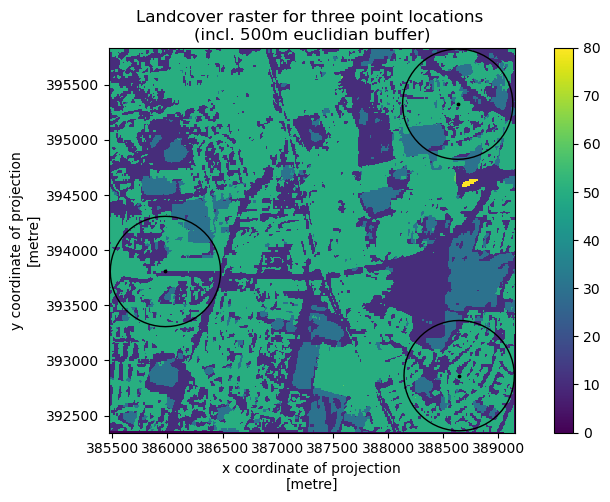

In [87]:
fig, ax = plt.subplots(figsize=(10, 5))

landcover_src.plot(ax=ax)
multi_point.plot(ax=ax, c="black", markersize=3)
multi_point.buffer(500).plot(ax=ax, edgecolor="black", facecolor="none")
ax.set_title('Landcover raster for three point locations \n(incl. 500m euclidian buffer)')

fig.savefig('C:/Users/ygrin/Documents/Studie - MSc ADS/Utrecht University/Block 4 - Thesis/GitHub/GreenEx_Py/Plots/landcover.png', bbox_inches='tight')

In [50]:
import pyproj
epsg_transformer = pyproj.Transformer.from_crs("epsg:27700", "epsg:4326")
latlon = epsg_transformer.transform(single_point['geometry'].x,single_point['geometry'].y)
network_osm = ox.graph_from_point(latlon, dist=1000)
network_osm_bng = ox.project_graph(network_osm, to_crs='EPSG:27700')

c:\Users\ygrin\anaconda3\envs\ADSthesis\Lib\site-packages\pyproj\transformer.py:812: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return self._transformer._transform_point(


In [51]:
center_node = ox.distance.nearest_nodes(network_osm_bng, single_point['geometry'].x,single_point['geometry'].y) 
# Calculate the time it takes to cover each edge's distance
meters_per_minute = 5 * 1000 / 60
for _, _, _, data in network_osm_bng.edges(data=True, keys=True): 
    data["time"] = data["length"] / meters_per_minute
# Compute isochrones, see separate function for line by line explanation
isochrone_poly = make_iso_poly(network_osm_bng, center_node=center_node[0], trip_time=10) 

In [52]:
aoi_gdf = gpd.GeoDataFrame(geometry=[isochrone_poly], crs="EPSG:27700")

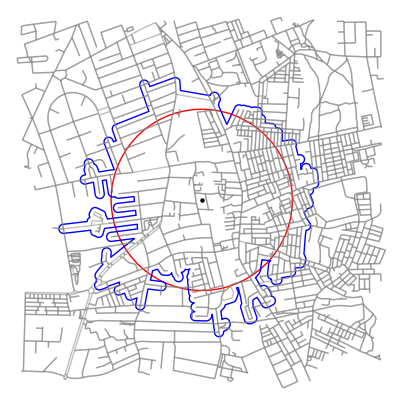

In [82]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))

single_point.plot(ax=ax, edgecolor='black', facecolor='black', markersize=5)
single_point.buffer(500).plot(ax=ax, edgecolor='red', facecolor='none')
aoi_gdf.plot(ax=ax, edgecolor='blue', facecolor='none')
ox.plot_graph(network_osm_bng, ax=ax, node_size=0, edge_color='gray', bgcolor='white', edge_alpha=0.5)

fig.savefig('C:/Users/ygrin/Documents/Studie - MSc ADS/Utrecht University/Block 4 - Thesis/GitHub/GreenEx_Py/Plots/eucl_network.png', bbox_inches='tight')
plt.show()



In [92]:
from IPython.display import Image

Image(url=selected_item.assets["rendered_preview"].href, width=500)